In [3]:
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer

In [4]:
from qiskit.test.mock import (
    FakeBogota,
    FakeCasablanca,
    FakeGuadalupe,
    FakeMontreal,
    FakeManhattan,
) 

In [5]:
# Score generator
# for each MQTbench circuit
    # for each compiler -> tket, staq, qiskit, forest, ...
        # for each backend -> Rigetti, IBM, Google?, AQT?, OQC?, Cirq, ProjectQ
            # generate circuit
            # calculate score
            # safe data: input: qasmfile/gate count per gate, compiler/compiler settings/machine -> output: score

In [55]:
rigetti_m1 = {
    "provider": "rigetti",
    "name": "m1",
    "num_qubits": 80,
    "t1_avg": 33.845,
    "t2_avg": 28.230,
    "avg_gate_time_1q": 60e-3, #source: https://qcs.rigetti.com/qpus -> ASPEN-M-1
    "avg_gate_time_2q": 160e-3 #source: https://qcs.rigetti.com/qpus -> ASPEN-M-1
}
ibm_washington = {
    "provider": "ibm",
    "name": "washington",
    "num_qubits": 127,
    "t1_avg": 103.39,
    "t2_avg": 97.75,
    "avg_gate_time_1q": 206e-3, #estimated, based on the rigetti relation between 1q and 2q and given avg 2q time
    "avg_gate_time_2q": 550.41e-3 #source: https://quantum-computing.ibm.com/services?services=systems&system=ibm_washington
}
ionq = {
    "provider": "ionq",
    "name": "washington",
    "num_qubits": 127,
    "t1_avg": 10000,
    "t2_avg": 0.2,
    "avg_gate_time_1q": 0.00001,
    "avg_gate_time_2q": 0.0002 
}

In [56]:
def count_qubit_gates(qc, provider:str):
    dag = circuit_to_dag(qc)
    count_gates = dag.count_ops_longest_path()
    single_qubit_gates = 0
    two_qubit_gates = 0
    if provider == "ibm":
        # gates: ['id', 'rz', 'sx', 'x', 'cx', 'reset']
        if "id" in count_gates:
            single_qubit_gates += count_gates["id"]
        if "rz" in count_gates:
            single_qubit_gates += count_gates["rz"]
        if "sx" in count_gates:
            single_qubit_gates += count_gates["sx"]
        if "x" in count_gates:
            single_qubit_gates += count_gates["x"]
        if "cx" in count_gates:
            two_qubit_gates += count_gates["cx"]
        
    elif provider == "rigetti":
        # gates: rigetti_native_gates = ["rx", "rz", "cz"]
        if "rx" in count_gates:
            single_qubit_gates += count_gates["rx"]
        if "rz" in count_gates:
            single_qubit_gates += count_gates["rz"]
        if "cz" in count_gates:
            two_qubit_gates += count_gates["cz"]
            
    elif provider == "ionq":
        # gates: ionq_native_gates = ["ms", "rz", "ry", "rx"]
        if "rx" in count_gates:
            single_qubit_gates += count_gates["rx"]
        if "ry" in count_gates:
            single_qubit_gates += count_gates["ry"]
        if "rz" in count_gates:
            single_qubit_gates += count_gates["rz"]
        if "ms" in count_gates:
            two_qubit_gates += count_gates["ms"]
    return single_qubit_gates, two_qubit_gates
        

In [57]:
def calc_score_from_str(qc:str, backend):
    qc = QuantumCircuit.from_qasm_str(qc)
    return calc_score(qc, backend)
    
def calc_score_from_path(filepath, backend):       
    qc = QuantumCircuit.from_qasm_file(filepath)
    return calc_score(qc, backend)
    
def calc_score(qc:QuantumCircuit, backend):
    count_gates = count_qubit_gates(qc, backend["provider"])
    #print("Gates: ", count_gates)
    penalty_factor_width = 5000
    penalty_factor_1q = 500
    penalty_factor_2q = 1000

    b_qubits = backend["num_qubits"]
    t_1 = backend["t1_avg"]
    t_2 = backend["t2_avg"]
    avg_gate_time_1q = backend["avg_gate_time_1q"]
    avg_gate_time_2q = backend["avg_gate_time_2q"]
    max_depth_1q = min(t_1, t_2) / avg_gate_time_1q
    max_depth_2q = min(t_1, t_2) / avg_gate_time_2q

    penalty_width = 0
    
    if qc.num_qubits > b_qubits:
        penalty_width = penalty_factor_width
        
    
    score = count_gates[0] / max_depth_1q * penalty_factor_1q + count_gates[1] / max_depth_2q * penalty_factor_2q + penalty_width
    #print("Score: ", score)
    return score

# Qiskit

In [58]:
ibm_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset']
rigetti_gates = ["rx", "rz", "cz"]
ionq_gates = ["rxx", "rz", "ry", "rx"]
aqt_gates = ['rx', 'ry', 'rxx']

In [59]:
from qiskit import transpile

opt_level=0
def get_qiskit_scores(qc_filepath:QuantumCircuit, opt_level=0):
    qc = QuantumCircuit.from_qasm_file(qc_filepath)
    #compile to ibm architecture
    qc_ibm = transpile(qc, basis_gates=ibm_gates, optimization_level=opt_level)
    #print(qc_ibm.draw())
    score_ibm = calc_score_from_str(qc_ibm.qasm(), ibm_washington)
    #compile to rigetti architecture
    qc_rigetti = transpile(qc, basis_gates=rigetti_gates, optimization_level=opt_level)
    #print(qc_rigetti.draw())
    score_rigetti = calc_score_from_str(qc_rigetti.qasm(), rigetti_m1)
    #compile to aqt architecture
    qc_aqt = transpile(qc, basis_gates=aqt_gates, optimization_level=opt_level)
    #print(qc_ion.draw())
    score_aqt = calc_score_from_str(qc_aqt.qasm(), ionq)
    #compile to rigetti architecture
    qc_ion = transpile(qc, basis_gates=ionq_gates, optimization_level=opt_level)
    #print(qc_ion.draw())
    score_ionq = calc_score_from_str(qc_ion.qasm(), ionq)
    #print("qiskit: ", score_ibm, score_rigetti, score_ionq)
    return [score_ibm, score_aqt, score_ionq, score_rigetti]

In [60]:
from qiskit_aqt_provider import AQTProvider
aqt = AQTProvider("")
AQT_backend = aqt.backends.aqt_qasm_simulator
AQT_backend.configuration().basis_gates

['rx', 'ry', 'rxx']

# Cirq

In [28]:
import cirq
from cirq.contrib.svg import SVGCircuit

def get_cirq_compilation(qasm_qc, target):
    if "ibm" in target:
        pass
    elif "rigetti" in target:
        pass
    elif "ionq" in target:
        pass

In [11]:
from cirq.contrib.qasm_import import circuit_from_qasm
test = open('../MQTbench/qasm_output/dj_indep_4.qasm', 'r').read()
ion_circuit = cirq.ion.ConvertToIonGates().convert_circuit(circuit)
print(ion_circuit)

NameError: name 'circuit' is not defined

In [ ]:
import cirq_rigetti
c = cirq_rigetti.circuit_transformers.default(circuit=circuit)
print(c)

SVGCircuit(c[0])

In [ ]:
import cirq
import cirq_ionq as ionq
q0 = cirq.LineQubit(0)
device = ionq.IonQAPIDevice([q0])
circuit = cirq.Circuit(device=device)
circuit.append(cirq.H(q0)**0.2) # Non-IonQ-API gate
print(circuit) # will print the circuit converted into IonQ's target gateset

# PyTKET

In [29]:
import pytket
a = pytket.architecture.Architecture([[1,0], [2,0]])
a.coupling

[(node[1], node[0]), (node[2], node[0])]

In [30]:
b1.rebase_pass()

NameError: name 'b1' is not defined

In [31]:
b2.rebase_pass()

NameError: name 'b2' is not defined

In [32]:
b3.rebase_pass()

NameError: name 'b3' is not defined

In [33]:
b4.rebase_pass()

NameError: name 'b4' is not defined

In [61]:
from pytket.extensions.qiskit import IBMQBackend
from pytket.extensions.aqt import AQTBackend
from pytket.extensions.qiskit import IBMQBackend
from pytket.extensions.pyquil import ForestBackend, ForestStateBackend
from pytket.extensions.ionq import IonQBackend
from pytket.circuit.display import render_circuit_jupyter
from pytket.passes import PlacementPass, RoutingPass, SequencePass
from pytket.placement import LinePlacement
from pytket.placement import GraphPlacement
import pytket
from pytket import qasm

def get_tket_scores(qc_filepath:QuantumCircuit):
    ibm_arch = pytket.architecture.Architecture(get_cmap_imbq_washington())
    rigetti_arch = pytket.architecture.Architecture(get_rigetti_c_map(10))

    b1 = IBMQBackend("ibmq_santiago")
    b2 = AQTBackend(device_name="sim/noise-model-1", access_token='')
    b3 = IonQBackend(api_key="")
    b4 = ForestStateBackend()
    c = qasm.circuit_from_qasm(qc_filepath)

    b1.rebase_pass().apply(c)
    PlacementPass(LinePlacement(ibm_arch)).apply(c)
    RoutingPass(ibm_arch).apply(c)
    b1.rebase_pass().apply(c)
    qc_qasm = qasm.circuit_to_qasm_str(c)
    score_ibm = calc_score_from_str(qc_qasm, ibm_washington)

    c = qasm.circuit_from_qasm(qc_filepath)
    b2.rebase_pass().apply(c)
    qc_qasm = qasm.circuit_to_qasm_str(c)
    score_aqt = calc_score_from_str(qc_qasm, ionq)

    c = qasm.circuit_from_qasm(qc_filepath)
    b3.rebase_pass().apply(c)
    qc_qasm = qasm.circuit_to_qasm_str(c)
    score_ionq = calc_score_from_str(qc_qasm, ionq)

    c = qasm.circuit_from_qasm(qc_filepath)
    b4.rebase_pass().apply(c)
    PlacementPass(LinePlacement(rigetti_arch)).apply(c)
    RoutingPass(ibm_arch).apply(c)
    b4.rebase_pass().apply(c)
    qc_qasm = qasm.circuit_to_qasm_str(c)
    score_rigetti = calc_score_from_str(qc_qasm, rigetti_m1)
    
    return [score_ibm, score_aqt, score_ionq, score_rigetti]

In [82]:
import os
i = 0
path_to_all_files = "../MQTbench/qasm_output"
res = dict()
res = []
for file in os.listdir(path_to_all_files):
    if "indep" in file:
        print(file)
        filepath = os.path.join(path_to_all_files, file)

        try:        
            res_qiskit = (get_qiskit_scores(filepath, opt_level=0))
            res_pytket = (get_tket_scores(filepath))
            for i in range(len(res_pytket)):
                if res_pytket[i] != 0:
                    score = (res_qiskit[i])/(res_pytket[i])
                    res.append(score)
        except Exception as e:
            print("fail: ", e)
        i+=1
        if i>100:
            break

grover-noancilla_indep_2.qasm
dj_indep_4.qasm
shor_15_2_indep_15.qasm
fail:  Cannot parse gate of type: cp
wstate_indep_8.qasm
portfolioqaoa_indep_5.qasm
dj_indep_5.qasm
qft_indep_8.qasm
fail:  Cannot parse gate of type: cp
grover-noancilla_indep_3.qasm
grover-noancilla_indep_4.qasm
ghz_indep_5.qasm
dj_indep_2.qasm
vqe_indep_5.qasm
pricingput_indep_5.qasm
qaoa_indep_5.qasm
qpeexact_indep_8.qasm
fail:  Cannot parse gate of type: cp
dj_indep_3.qasm
grover-noancilla_indep_5.qasm
ae_indep_8.qasm
fail:  Cannot parse gate of type: cp
hhl_indep_2.qasm
fail:  Cannot parse gate of type: cu
qpeinexact_indep_8.qasm
fail:  Cannot parse gate of type: cp
qftentangled_indep_8.qasm
fail:  Cannot parse gate of type: cp
grover-v-chain_indep_5.qasm
fail:  Cannot parse gate of type: rccx
grover-v-chain_indep_4.qasm
qgan_indep_5.qasm
grover_indep_5.qasm
fail:  Cannot parse gate of type: rccx
hhl_indep_8.qasm
fail:  Cannot parse gate of type: cu
vqerandom_indep_8.qasm
grover-v-chain_indep_3.qasm
pricingcall

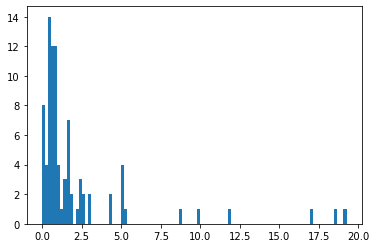

In [80]:
from matplotlib import pyplot as plt
#plt.xscale("log")
plt.hist(res, bins=100);

In [17]:
def get_cmap_imbq_washington():
    """Returns the coupling map of the IBM-Q washington quantum computer."""
    c_map_ibmq_washington = [
        [0, 1],
        [1, 2],
        [2, 3],
        [3, 4],
        [4, 5],
        [5, 6],
        [6, 7],
        [7, 8],
        [0, 14],
        [14, 18],
        [18, 19],
        [19, 20],
        [20, 21],
        [21, 22],
        [4, 15],
        [15, 22],
        [22, 23],
        [23, 24],
        [24, 25],
        [25, 26],
        [8, 16],
        [16, 26],
        [26, 27],
        [27, 28],
        [28, 29],
        [29, 30],
        [30, 31],
        [31, 32],
        [9, 10],
        [10, 11],
        [11, 12],
        [12, 13],
        [12, 17],
        [17, 30],
        [32, 36],
        [36, 51],
        [20, 33],
        [33, 39],
        [24, 34],
        [34, 43],
        [28, 35],
        [35, 47],
        [37, 38],
        [38, 39],
        [39, 40],
        [40, 41],
        [41, 42],
        [42, 43],
        [43, 44],
        [44, 45],
        [45, 46],
        [46, 47],
        [47, 48],
        [48, 49],
        [49, 50],
        [50, 51],
        [37, 52],
        [52, 56],
        [41, 53],
        [53, 60],
        [45, 54],
        [54, 64],
        [49, 55],
        [55, 68],
        [56, 57],
        [57, 58],
        [58, 59],
        [59, 60],
        [60, 61],
        [61, 62],
        [62, 63],
        [63, 64],
        [64, 65],
        [65, 66],
        [66, 67],
        [67, 68],
        [68, 69],
        [69, 70],
        [70, 74],
        [74, 89],
        [58, 71],
        [71, 77],
        [62, 72],
        [72, 81],
        [66, 73],
        [73, 85],
        [75, 76],
        [76, 77],
        [77, 78],
        [78, 79],
        [79, 80],
        [80, 81],
        [81, 82],
        [82, 83],
        [83, 84],
        [84, 85],
        [85, 86],
        [86, 87],
        [87, 88],
        [88, 89],
        [75, 90],
        [90, 94],
        [79, 91],
        [91, 98],
        [83, 92],
        [92, 102],
        [87, 93],
        [93, 106],
        [94, 95],
        [95, 96],
        [96, 97],
        [97, 98],
        [98, 99],
        [99, 100],
        [100, 101],
        [101, 102],
        [102, 103],
        [103, 104],
        [104, 105],
        [105, 106],
        [106, 107],
        [107, 108],
        [108, 112],
        [112, 126],
        [96, 109],
        [100, 110],
        [110, 118],
        [104, 111],
        [111, 122],
        [113, 114],
        [114, 115],
        [115, 116],
        [116, 117],
        [117, 118],
        [118, 119],
        [119, 120],
        [120, 121],
        [121, 122],
        [122, 123],
        [123, 124],
        [124, 125],
        [125, 126],
    ]

    inverted = [[item[1], item[0]] for item in c_map_ibmq_washington]
    c_map_ibmq_washington = c_map_ibmq_washington + inverted
    return c_map_ibmq_washington

In [18]:
def get_rigetti_c_map(circles: int = 4):
    """Returns a coupling map of the circular layout scheme used by Rigetti.

    Keyword arguments:
    circles -- number of circles, each one comprises 8 qubits
    """
    if circles != 10:
        c_map_rigetti = []
        for j in range(circles):
            for i in range(0, 7):
                c_map_rigetti.append([i + j * 8, i + 1 + j * 8])

                if i == 6:
                    c_map_rigetti.append([0 + j * 8, 7 + j * 8])

            if j != 0:
                c_map_rigetti.append([j * 8 - 6, j * 8 + 5])
                c_map_rigetti.append([j * 8 - 7, j * 8 + 6])

        inverted = [[item[1], item[0]] for item in c_map_rigetti]
        c_map_rigetti = c_map_rigetti + inverted
    else:
        c_map_rigetti = []
        for j in range(5):
            for i in range(0, 7):
                c_map_rigetti.append([i + j * 8, i + 1 + j * 8])

                if i == 6:
                    c_map_rigetti.append([0 + j * 8, 7 + j * 8])

            if j != 0:
                c_map_rigetti.append([j * 8 - 6, j * 8 + 5])
                c_map_rigetti.append([j * 8 - 7, j * 8 + 6])

        for j in range(5):
            m = 8 * j + 5 * 8
            for i in range(0, 7):
                c_map_rigetti.append([i + m, i + 1 + m])

                if i == 6:
                    c_map_rigetti.append([0 + m, 7 + m])

            if j != 0:
                c_map_rigetti.append([m - 6, m + 5])
                c_map_rigetti.append([m - 7, m + 6])

        for n in range(5):
            c_map_rigetti.append([n * 8 + 3, n * 8 + 5 * 8])
            c_map_rigetti.append([n * 8 + 4, n * 8 + 7 + 5 * 8])

        inverted = [[item[1], item[0]] for item in c_map_rigetti]
        c_map_rigetti = c_map_rigetti + inverted

    return c_map_rigetti

# Pennylane

In [ ]:
import pennylane as qml
from pennylane import numpy as np

In [ ]:
ibm_native_gates = FakeMontreal().configuration().basis_gates
rigetti_native_gates = ["rx", "rz", "cz"]
ibm_native_gates

dev = qml.device('default.qubit', wires=[0, 1, 2])
qnode = qml.QNode(qfunc, dev)
print(qml.draw(qnode)(0.2, 0.3, 0.4))

compiled_qfunc = qml.compile(basis_set=rigetti_native_gates)(qfunc)
compiled_qnode = qml.QNode(compiled_qfunc, dev)
print(qml.draw(compiled_qnode)(0.2, 0.3, 0.4))

In [ ]:
path_file = "../MQTbench/qasm_output/dj_indep_4.qasm"
with open (path_file, "r") as myfile:
    data = myfile.read()
my_circuit = qml.from_qasm(data)

n=4
dev = qml.device('default.qubit', wires=n)
@qml.qnode(dev)
def circuit():
    my_circuit(wires=tuple(range(n)))
    return [qml.expval(qml.PauliZ(i)) for i in range(n)]

#circuit()
#print(dev._circuit.qasm(formatted=True))

In [ ]:
pennylane_ibm=["RZ", "SX", "PauliX", "CNOT"]
pennylane_rigetti=["RX", "RZ", "CZ"]

In [ ]:
compiled_qfunc1 = qml.compile()(circuit)
compiled_qnode1 = qml.QNode(compiled_qfunc1, dev)
print(qml.draw(compiled_qnode1)())

compiled_qfunc2 = qml.compile(
    basis_set=["CNOT", "RX", "RY", "RZ"],
    num_passes=2
)(circuit)

compiled_qnode2 = qml.QNode(compiled_qfunc2, dev)
print(qml.draw(compiled_qnode2)())

In [ ]:
def qfunc(x, y, z):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.RZ(z, wires=2)
    qml.CNOT(wires=[2, 1])
    qml.RX(z, wires=0)
    qml.CNOT(wires=[1, 0])
    qml.RX(x, wires=0)
    qml.CNOT(wires=[1, 0])
    qml.RZ(-z, wires=2)
    qml.RX(y, wires=2)
    qml.PauliY(wires=2)
    qml.CY(wires=[1, 2])
    return qml.expval(qml.PauliZ(wires=0))

dev = qml.device('default.qubit', wires=[0, 1, 2])
qnode = qml.QNode(qfunc, dev)
print(qml.draw(qnode)(0.2, 0.3, 0.4))

compiled_qfunc = qml.compile(
    pipeline=[
        qml.transforms.commute_controlled(direction="left"),
        qml.transforms.merge_rotations(atol=1e-6),
        qml.transforms.cancel_inverses
    ],
    basis_set=["CNOT", "RX", "RY", "CZ"],
    num_passes=2
)(qfunc)

compiled_qnode = qml.QNode(compiled_qfunc, dev)
print(qml.draw(compiled_qnode)(0.2, 0.3, 0.4))

In [ ]:
def qfunc():
    qml.Hadamard(wires=0)    
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.RZ(-0.4, wires=2)
    qml.CNOT(wires=[2, 1])
    qml.RX(-0.4, wires=0)
    qml.CNOT(wires=[1, 0])
    qml.RX(-0.4, wires=0)
    qml.CNOT(wires=[1, 0])
    qml.RZ(-0.4, wires=2)
    qml.RX(1, wires=2)
    qml.PauliY(wires=2)
    qml.CY(wires=[1, 2])
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

dev = qml.device('default.qubit', wires=[0, 1, 2])
qnode = qml.QNode(qfunc, dev)
print(qml.draw(qnode)())

compiled_qfunc = qml.compile(
    basis_set=["CNOT", "Rdawd", "wdfawdaw", "dawd"],
    num_passes=20
)(qfunc)

compiled_qnode = qml.QNode(compiled_qfunc, dev)
print(qml.draw(compiled_qnode)())

# Old